In [71]:
#hide
from fastai.vision.all import *
from utils import *

matplotlib.rc('image', cmap='Greys')

# Under the hood: training a digit classifier

## Pixels: the foundations of computer vision

## Sidebar: Tenacity and deep learning

## End sidebar

In [12]:
path = untar_data(URLs.MNIST_SAMPLE)

In [13]:
#hide
Path.BASE_PATH = path

In [14]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [15]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [16]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [17]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [18]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [19]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [20]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First try: pixel similarity

In [21]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

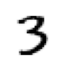

In [22]:
show_image(three_tensors[1]);

In [23]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [24]:
len(stacked_threes.shape)

3

In [25]:
stacked_threes.ndim

3

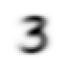

In [53]:
mean3 = stacked_threes.mean(0) # fix the other dimensions, only take mean on the dimension 0 (cross all images), get an average image
show_image(mean3);

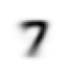

In [54]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

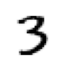

In [56]:
a_3 = stacked_threes[1]
show_image(a_3);

In [29]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [57]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [58]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy arrays and PyTorch tensors

In [32]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [33]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [34]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [35]:
tns[1]

tensor([4, 5, 6])

In [36]:
tns[:,1]

tensor([2, 5])

In [37]:
tns[1,1:3]

tensor([5, 6])

In [38]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [39]:
tns.type()

'torch.LongTensor'

In [40]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Broadcasting and metrics

In [59]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [61]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) 
mnist_distance(a_3, mean3)

tensor(0.1114)

-1, -2 means to taking mean on last two dimensions (pixel dimensions) (by sqh)

In [62]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1187, 0.1382, 0.1368,  ..., 0.1124, 0.1092, 0.1086]),
 torch.Size([1010]))

In [44]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [63]:
(valid_3_tens-mean3).shape 

torch.Size([1010, 28, 28])

Although valid_3_tens has three dimensions, but mean3 has two dimensions only, pytorch finds that the last few dimensions matched, it can still calculate the formula, called broadcasting. 

If the first two dimensions matched, it doesn't work. 

If only the last dimension matched, it works.

https://www.youtube.com/watch?v=bI2P4etSwgE&list=PLaEH8RgowXnANfpwe4wioH_QNcvC_x_vd&index=3 (by sqh)

In [64]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [65]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [66]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [67]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient descent (SGD)

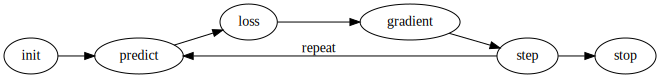

In [50]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [51]:
def f(x): return x**2

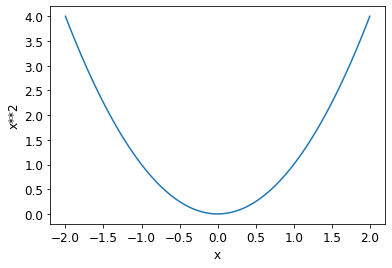

In [73]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, steps=100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

plot_function(f, 'x', 'x**2')

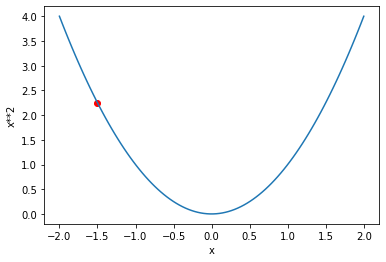

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

## The gradient

In [74]:
xt = tensor(3.).requires_grad_()

In [75]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [76]:
yt.backward()

In [77]:
xt.grad

tensor(6.)

In [78]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [79]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [80]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## The loss function

In [81]:
def mnist_loss(inputs, targets):
    return torch.where(targets==1, 1-inputs, inputs).mean()

The reason to have loss function is because loss function has grident, but final goal might not have. (by sqh from video)

In [82]:
tgt = tensor([1,0,1])
inp = tensor([0.9, 0.4, 0.2])

In [83]:
torch.where(tgt==1, 1-inp, inp)

tensor([0.1000, 0.4000, 0.8000])

In [84]:
mnist_loss(inp,tgt)

tensor(0.4333)

In [85]:
mnist_loss(tensor([0.9, 0.4, 0.8]),tgt)

tensor(0.2333)

### Sigmoid

In [86]:
def sigmoid(x): return 1/(1+torch.exp(-x))

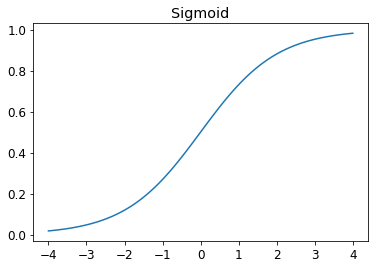

In [87]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [88]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

### Sidebar: loss versus metric

### End sidebar

## Stepping with a learning rate

### Summarizing gradient descent

## Stochastic gradient descent and mini-batches

In [89]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [90]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [91]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting it all together

In [92]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [93]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [94]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [95]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [96]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

In [97]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [98]:
weights = init_params((28*28,1))

In [99]:
bias = init_params(1)

In [100]:
(train_x[0]*weights.T).sum() + bias

tensor([4.5118], grad_fn=<AddBackward0>)

In [101]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [102]:
def linear1(xb): return xb@weights + bias
preds = linear1(batch)
preds

tensor([[ 4.5118],
        [ 3.6536],
        [11.2975],
        [14.1164]], grad_fn=<AddBackward0>)

In [103]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0090, grad_fn=<MeanBackward0>)

In [104]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0013), tensor([-0.0088]))

In [105]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [106]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0025), tensor([-0.0177]))

In [107]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0038), tensor([-0.0265]))

In [108]:
weights.grad.zero_()
bias.grad.zero_();

In [109]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [110]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [111]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [112]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [113]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [114]:
validate_epoch(linear1)

0.4402

In [115]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4992

In [116]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6771 0.808 0.914 0.9452 0.9565 0.9618 0.9623 0.9633 0.9657 0.9677 0.9701 0.9716 0.9721 0.9736 0.974 0.9745 0.9765 0.977 0.977 0.9765 

### Creating an optimizer

In [117]:
linear_model = nn.Linear(28*28,1)

In [118]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [119]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [120]:
opt = BasicOptim(linear_model.parameters(), lr)

In [121]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [122]:
validate_epoch(linear_model)

0.6712

In [123]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [124]:
train_model(linear_model, 20)

0.4932 0.7934 0.8476 0.9165 0.9346 0.9482 0.956 0.9633 0.9658 0.9672 0.9702 0.9716 0.9731 0.9751 0.9755 0.9765 0.9775 0.978 0.9785 0.9785 

In [125]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.771 0.8594 0.9179 0.9355 0.9492 0.9575 0.9633 0.9658 0.9682 0.9692 0.9716 0.9731 0.9751 0.9755 0.977 0.977 0.9785 0.9785 0.9785 

In [126]:
dls = DataLoaders(dl, valid_dl)

In [127]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [128]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636918,0.503445,0.495584,00:03
1,0.500283,0.192597,0.839549,00:03
2,0.184349,0.182295,0.833660,00:03
3,0.081278,0.107260,0.912169,00:03
4,0.043316,0.078320,0.932777,00:03
5,0.028503,0.062712,0.946025,00:03
6,0.022414,0.052999,0.955348,00:03
7,0.019704,0.046531,0.962218,00:03
8,0.018323,0.041979,0.965653,00:03
9,0.017486,0.038622,0.966634,00:03


## Adding a non-linearity

In [129]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [130]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

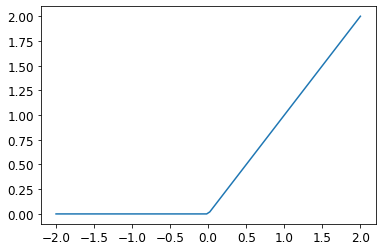

In [131]:
plot_function(F.relu)

In [132]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [133]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [134]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.382564,0.383547,0.535329,00:12
1,0.170641,0.258647,0.773307,00:11
2,0.090678,0.123939,0.911187,00:11
3,0.057028,0.081206,0.938665,00:11
4,0.041828,0.062664,0.954367,00:08
5,0.034317,0.052488,0.963199,00:12
6,0.030163,0.046119,0.964671,00:11
7,0.027555,0.041781,0.966634,00:10
8,0.025724,0.038640,0.968106,00:11
9,0.024330,0.036244,0.969087,00:13


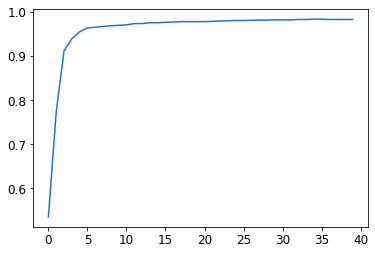

In [135]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [136]:
learn.recorder.values[-1][2]

0.98233562707901

In [137]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/home/shengq2/anaconda3/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/shengq2/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shengq2/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.117364,0.019553,0.993621,00:42


## Deep learning

### _Choose Your Own Adventure_ reminder

## Questionnaire

### Further research